# 卷积神经网络  

本代码参考：https://github.com/WZMIAOMIAO/deep-learning-for-image-processing 推荐自学

## 1 AlexNet-对花进行分类 

### 1.1 Pytorch定义AlexNet

In [1]:
import torch.nn as nn
import torch
import os
import json

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt


class AlexNet(nn.Module):
    def __init__(self, num_classes=1000, init_weights=False):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2),  # input[3, 224, 224]  output[48, 55, 55]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[48, 27, 27]
            nn.Conv2d(48, 128, kernel_size=5, padding=2),           # output[128, 27, 27]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 13, 13]
            nn.Conv2d(128, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),          # output[192, 13, 13]
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 128, kernel_size=3, padding=1),          # output[128, 13, 13]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 6, 6]
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128 * 6 * 6, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


## 1.2 下载数据，划分训练集和验证集 

* （1）创建新文件夹"flower_data"
* （2）点击链接下载花分类数据集 [https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)
* （3）解压数据集到flower_data文件夹下
* （4）执行"split_data.py"脚本自动将数据集划分成训练集train和验证集val    

```
├── flower_data   
       ├── flower_photos（解压的数据集文件夹，3670个样本）  
       ├── train（生成的训练集，3306个样本）  
       └── val（生成的验证集，364个样本） 
``` 

In [2]:
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm


In [3]:
import os
from shutil import copy, rmtree
import random


def mk_file(file_path: str):
    if os.path.exists(file_path):
        # 如果文件夹存在，则先删除原文件夹在重新创建
        rmtree(file_path)
    os.makedirs(file_path)


def main():
    # 保证随机可复现
    random.seed(0)

    # 将数据集中10%的数据划分到验证集中
    split_rate = 0.2

    # 指向你解压后的flower_photos文件夹
    #cwd = os.getcwd()
    #data_root = os.path.join("./", "flower_data") 
    data_root  = "./"
    origin_flower_path = "./flower_photos"
    assert os.path.exists(origin_flower_path), "path '{}' does not exist.".format(origin_flower_path)

    flower_class = [cla for cla in os.listdir(origin_flower_path)
                    if os.path.isdir(os.path.join(origin_flower_path, cla))]

    # 建立保存训练集的文件夹
    train_root = os.path.join(data_root, "train")
    mk_file(train_root)
    for cla in flower_class:
        # 建立每个类别对应的文件夹
        mk_file(os.path.join(train_root, cla))

    # 建立保存验证集的文件夹
    val_root = os.path.join(data_root, "val")
    mk_file(val_root)
    for cla in flower_class:
        # 建立每个类别对应的文件夹
        mk_file(os.path.join(val_root, cla))

    for cla in flower_class:
        cla_path = os.path.join(origin_flower_path, cla)
        images = os.listdir(cla_path)
        num = len(images)
        # 随机采样验证集的索引
        eval_index = random.sample(images, k=int(num*split_rate))
        for index, image in enumerate(images):
            if image in eval_index:
                # 将分配至验证集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(val_root, cla)
                copy(image_path, new_path)
            else:
                # 将分配至训练集中的文件复制到相应目录
                image_path = os.path.join(cla_path, image)
                new_path = os.path.join(train_root, cla)
                copy(image_path, new_path)
            print("\r[{}] processing [{}/{}]".format(cla, index+1, num), end="")  # processing bar
        print()

    print("processing done!")


main()


[daisy] processing [633/633]
[dandelion] processing [898/898]
[roses] processing [641/641]
[sunflowers] processing [699/699]
[tulips] processing [799/799]
processing done!


### 1.3 训练 

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((224, 224)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [5]:
from torchvision import datasets, utils
train_dataset = datasets.ImageFolder(root="./train",transform=data_transform["train"])
train_num = len(train_dataset)

In [6]:
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open('class_indices.json', 'w') as json_file:
    json_file.write(json_str)

In [7]:
batch_size = 32
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=nw)

validate_dataset = datasets.ImageFolder(root= "./val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=4, shuffle=False,
                                              num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num,val_num))

Using 8 dataloader workers every process
using 2939 images for training, 731 images for validation.


In [8]:
import torch.optim as optim
net = AlexNet(num_classes=5, init_weights=True)

net.to(device)
loss_function = nn.CrossEntropyLoss()
# pata = list(net.parameters())
optimizer = optim.Adam(net.parameters(), lr=0.0002)

epochs = 10
save_path = './AlexNet.pth'
best_acc = 0.0
train_steps = len(train_loader)

In [9]:
from tqdm import tqdm
for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

print('Finished Training')


100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:07<00:00, 23.78it/s]
[epoch 1] train_loss: 1.385  val_accuracy: 0.505
100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:07<00:00, 23.21it/s]
[epoch 2] train_loss: 1.204  val_accuracy: 0.472
100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:07<00:00, 23.63it/s]
[epoch 3] train_loss: 1.129  val_accuracy: 0.547
100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:08<00:00, 22.08it/s]
[epoch 4] train_loss: 1.081  val_accuracy: 0.602
100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:08<00:00, 22.77it/s]
[epoch 5] train_loss: 1.025  val_accuracy: 0.655
100%|████████████████████████████████████████████████████████████████████████████████| 183/183 [00:09<00:00, 19.86it/s]
[epoch 6] train_loss: 0.966  val_ac

### 1.4 预测 


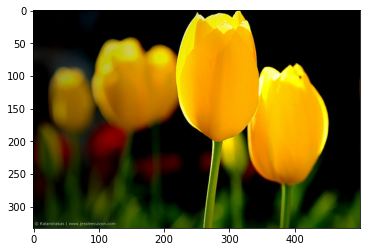

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load image
img_path = "./tulip.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

In [11]:
# read class_indict
json_path = './class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

with open(json_path, "r") as f:
    class_indict = json.load(f)

# create model
model = AlexNet(num_classes=5).to(device)

# load model weights
weights_path = "./AlexNet.pth"
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

class: daisy        prob: 0.0521
class: dandelion    prob: 0.134
class: roses        prob: 0.138
class: sunflowers   prob: 0.312
class: tulips       prob: 0.364


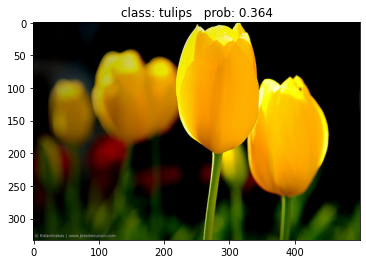

In [12]:
# load image
img_path = "./tulip.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

model.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(model(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                             predict[predict_cla].numpy())
plt.title(print_res)
for i in range(len(predict)):
    print("class: {:10}   prob: {:.3}".format(class_indict[str(i)],
                                              predict[i].numpy()))
plt.show()

## 2 使用torchvision的AlexNet模型

In [ ]:
from torchvision import models
import torch

dir(models)

In [14]:
alexnet = models.alexnet(pretrained=True)

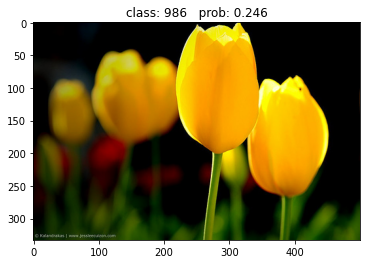

In [15]:
# load image
img_path = "./tulip.jpg"
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
img = Image.open(img_path)

plt.imshow(img)
# [N, C, H, W]
img = data_transform(img)
# expand batch dimension
img = torch.unsqueeze(img, dim=0)

alexnet.eval()
with torch.no_grad():
    # predict class
    output = torch.squeeze(alexnet(img.to(device))).cpu()
    predict = torch.softmax(output, dim=0)
    predict_cla = torch.argmax(predict).numpy()

print_res = "class: {}   prob: {:.3}".format(str(predict_cla),
                                             predict[predict_cla].numpy())
plt.title(print_res)

plt.show()